In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_00141_LEFT_MLO_1-1.3.6.1.4.1.9590.100.1.2.132470396811132802311388148633431047614-1.3.6.1.4.1.9590.100.1.2.319647729912087119402966470430252610901-000001._BENIGN-roi.png
/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_01773_RIGHT_CC_1-1.3.6.1.4.1.9590.100.1.2.251873479111874220326365927782688038525-1.3.6.1.4.1.9590.100.1.2.411332629211742096700949712693333832845-000001._BENIGN-roi.png
/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_01882_LEFT_MLO_1-1.3.6.1.4.1.9590.100.1.2.256905759811225865232082510450884767166-1.3.6.1.4.1.9590.100.1.2.58322137412485391810382982722027426694-000001._BENIGN-roi.png
/kaggle/input/cbis-ddsmpatched/CBIS_DDSM/png_images/calc_case_description_test_set/Calc-Test_P_01058_LEFT_MLO_1-1.3.6.1.4.1.9590.100.1.2.280045004412750688539985071920278671695-1.3.6.1.4.1.9590.100.1.2.4181

### Reference for the repository of CBIS-DDSM:
*    Title: MedicalCNN
*    Author: Lai, Leonardo
*    Date: 04/2021
*    Version: 1.0
*    Availability: https://github.com/leoll2/MedicalCNN.git

# VGG16 Transfer Learning on CBIS DDSM

This notebook exploits Transfer Learning on the VGG16 CNN architecture (pre-trained on ImageNet) for abnormality classification (mass-calcification, benign-malign) on mammography images taken from the CBIS DDSM dataset.

In [26]:
import sys
import pickle
import itertools
import re

import tensorflow as tf

from tensorflow import keras
from keras import models, optimizers, regularizers, layers
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from keras.utils import plot_model, to_categorical
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.regularizers import l2, l1

# path manipulation
from pathlib import Path

# image manipulation
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

In [27]:
cbis_path = '/kaggle/input/cbis-ddsmpatched/CBIS_DDSM'

### The data is prepared following these steps:


1.   Import the training and testing data from numpy arrays
2.   Remove the images and labels related to baseline patches (even indices in the arrays)
3.   Adjust the labels for the classification problem, so that 0 corresponds to 'benign mass', 1 to 'malignant mass', 2 to 'bening calcification' and 3 to 'malignant calcification'
4.   Normalize the pixels to be in the range (0-1) floating point
5.   Replicate the color channel three times, since VGG expects BGR images as input.
6.   Shuffle the training set (and labels accordingly, of course)
7.   Split the training data into 'training' and 'validation' subsets
8.   Build Keras generators for training and validation data

In [65]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [66]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_gen = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
val_gen = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2676 	 Test size: 336
Image size: 150x150


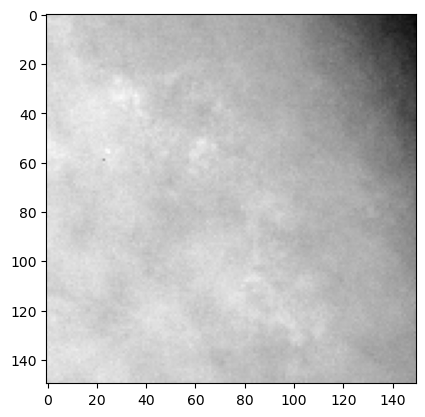

Label: [0. 0. 1. 0.]


In [30]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

In [31]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    vgg16 = Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False

    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [32]:
vgg16_base = VGG16(weights = "imagenet", include_top=False, input_shape=(150, 150, 3))
vgg16_base.trainable = False ## Not trainable weights
vgg16=Sequential()
vgg16.add(vgg16_base)
vgg16.add(Flatten())
# vgg16.add(BatchNormalization())
vgg16.add(Dense(64, activation = 'relu'))
# vgg16.add(BatchNormalization())
vgg16.add(Dropout(0.25))
vgg16.add(Dense(4, activation='softmax'))
vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                524352    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 15,239,300
Trainable params: 524,612
Non-trainable params: 14,714,688
_________________________________________________________________


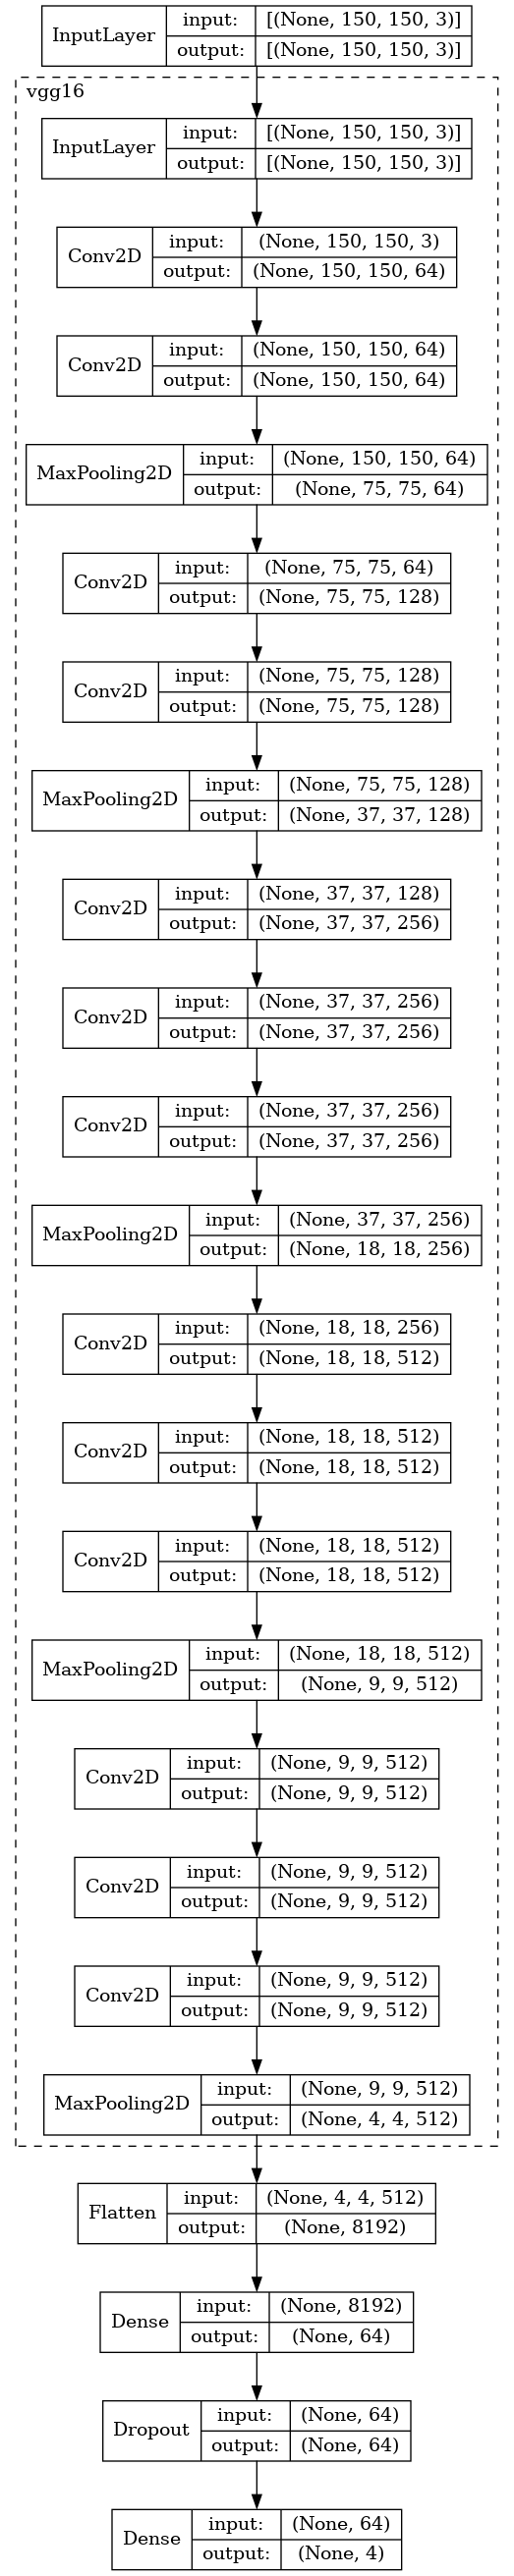

In [33]:
# Show the VGG16 architecture

# vgg16_example = create_vgg16(verbose=True)
plot_model(vgg16, to_file='vgg16_4class.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

In [34]:
# set optmizer and learning rate
adam = Adam(0.001)

vgg16.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# set callbacks
earlystopping = EarlyStopping(monitor='val_loss', patience=30, mode = 'min', verbose = 1)

checkpoint = ModelCheckpoint('vgg16.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Train the model
history = vgg16.fit(
        train_gen,
        steps_per_epoch=n_train_img // 128,
        epochs=150,
        validation_data=val_gen,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)




Epoch 1/150
17/17 [==============================] - ETA: 0s - loss: 1.5836 - accuracy: 0.4232
Epoch 1: val_loss improved from inf to 1.19846, saving model to vgg16.h5
17/17 [==============================] - 17s 957ms/step - loss: 1.5836 - accuracy: 0.4232 - val_loss: 1.1985 - val_accuracy: 0.4897
Epoch 2/150
17/17 [==============================] - ETA: 0s - loss: 1.1362 - accuracy: 0.4886
Epoch 2: val_loss did not improve from 1.19846
17/17 [==============================] - 16s 926ms/step - loss: 1.1362 - accuracy: 0.4886 - val_loss: 1.2040 - val_accuracy: 0.5477
Epoch 3/150
17/17 [==============================] - ETA: 0s - loss: 1.0630 - accuracy: 0.5292
Epoch 3: val_loss improved from 1.19846 to 1.09802, saving model to vgg16.h5
17/17 [==============================] - 15s 885ms/step - loss: 1.0630 - accuracy: 0.5292 - val_loss: 1.0980 - val_accuracy: 0.5458
Epoch 4/150
17/17 [==============================] - ETA: 0s - loss: 1.0400 - accuracy: 0.5418
Epoch 4: val_loss improved 

In [ ]:
# Save
models.save_model(vgg16, 'vgg16.h5')

In [67]:
# History of accuracy and loss
tra_loss = history.history['loss']
tra_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Total number of epochs training
epochs = range(1, len(tra_acc)+1)
end_epoch = len(tra_acc)

# Epoch when reached the validation loss minimum
opt_epoch = val_loss.index(min(val_loss)) + 1

# Loss and accuracy on the validation set
end_val_loss = val_loss[-1]
end_val_acc = val_acc[-1]
opt_val_loss = val_loss[opt_epoch-1]
opt_val_acc = val_acc[opt_epoch-1]

# Loss and accuracy on the test set
opt_vgg16 = models.load_model('vgg16.h5')
test_loss, test_acc = vgg16.evaluate(test_images, test_labels, verbose=False)
opt_test_loss, opt_test_acc = opt_vgg16.evaluate(test_images, test_labels, verbose=False)

print("VGG16 \n")

print("Model Result\n")
print("Epoch [end]: %d" % end_epoch)
print("Epoch [opt]: %d\n" % opt_epoch)
print("Valid accuracy [end]: %.4f" % end_val_acc)
print("Valid accuracy [opt]: %.4f" % opt_val_acc)
print("Test accuracy [end]:  %.4f" % test_acc)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc)
print("Valid loss [end]: %.4f" % end_val_loss)
print("Valid loss [opt]: %.4f" % opt_val_loss)
print("Test loss [end]:  %.4f" % test_loss)
print("Test loss [opt]:  %.4f" % opt_test_loss)

VGG16 

Model Result

Epoch [end]: 131
Epoch [opt]: 101

Valid accuracy [end]: 0.6187
Valid accuracy [opt]: 0.6336
Test accuracy [end]:  0.5625
Test accuracy [opt]:  0.5625

Valid loss [end]: 0.9143
Valid loss [opt]: 0.8296
Test loss [end]:  0.9894
Test loss [opt]:  0.9894


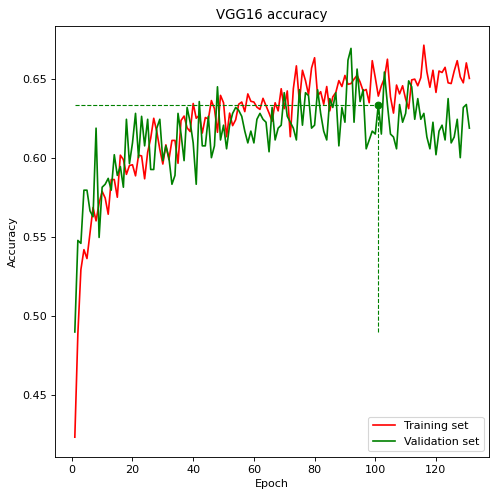

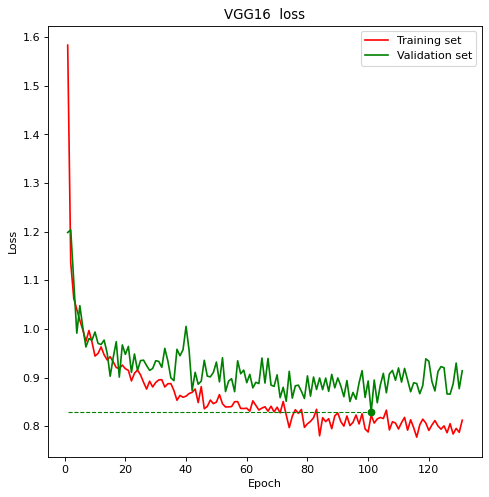

In [40]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs, tra_acc, 'r', label='Training set')
plt.plot(epochs, val_acc, 'g', label='Validation set')
plt.plot(opt_epoch, val_acc[opt_epoch-1], 'go')
plt.vlines(opt_epoch, min(val_acc), opt_val_acc, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc, 1, opt_epoch, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Accuracy_figure.png')
# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16  loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs, tra_loss, 'r', label='Training set')
plt.plot(epochs, val_loss, 'g', label='Validation set')
plt.plot(opt_epoch, val_loss[opt_epoch-1], 'go')
plt.vlines(opt_epoch, min(val_loss), opt_val_loss, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss, 1, opt_epoch, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Loss_figure.png')

In [41]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

11/11 [==============================] - 1s 33ms/step


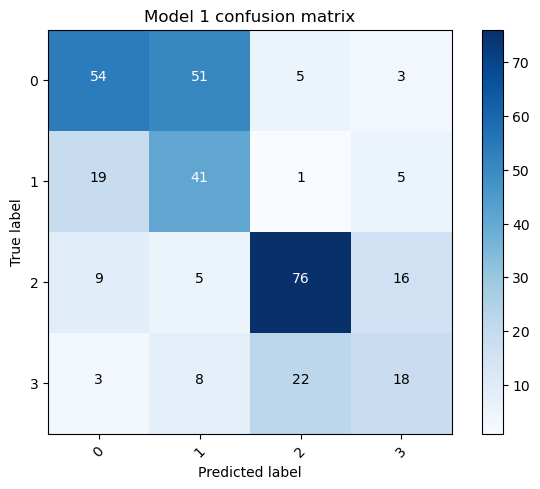

In [42]:
val_pred = np.argmax(opt_vgg16.predict(test_images), axis=-1)
# pred_1_classes = opt_model_1.predict(test_images)
confusion_mtx = confusion_matrix(test_labels_raw, val_pred) 
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Model 1 confusion matrix')
plt.savefig('ConfusionMatrix.png')

## Transfer Learning with VGG16 for Binary Classification of Mass and Calcification

### The data is prepared following these steps:


1.   Import the training and testing data from numpy arrays
2.   Remove the images and labels related to baseline patches (even indices in the arrays)
3.   Adjust the labels for the binary classification problem, so that 0 corresponds to 'mass' and 1 maps to 'calcification'
4.   Normalize the pixels to be in the range (0-1) floating point
5.   Replicate the color channel three times, since VGG expects BGR images as input.
6.   Shuffle the training set (and labels accordingly, of course)
7.   Split the training data into 'training' and 'validation' subsets
8.   Build Keras generators for training and validation data

In [43]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [44]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_gen = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
val_gen = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2676 	 Test size: 336
Image size: 150x150


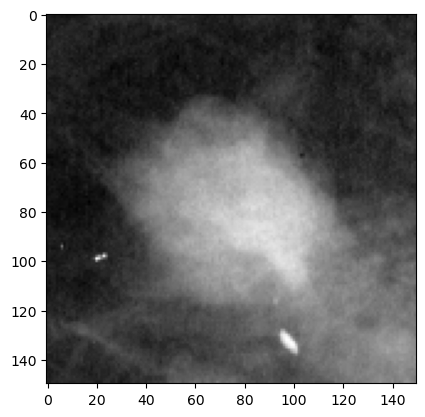

Label: 0
Label 0->mass 1->calcification


In [45]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct


idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))
print("Label 0->mass 1->calcification")

In [46]:
vgg16_base = VGG16(weights = "imagenet", include_top=False, input_shape=(150, 150, 3))
vgg16_base.trainable = False ## Not trainable weights
vgg16_binary=Sequential()
vgg16_binary.add(vgg16_base)
vgg16_binary.add(Flatten())
# vgg16.add(BatchNormalization())
vgg16_binary.add(Dense(128, activation = 'relu'))
# vgg16.add(BatchNormalization())
vgg16_binary.add(Dropout(0.25))
vgg16_binary.add(Dense(1, activation='sigmoid'))

vgg16_binary.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


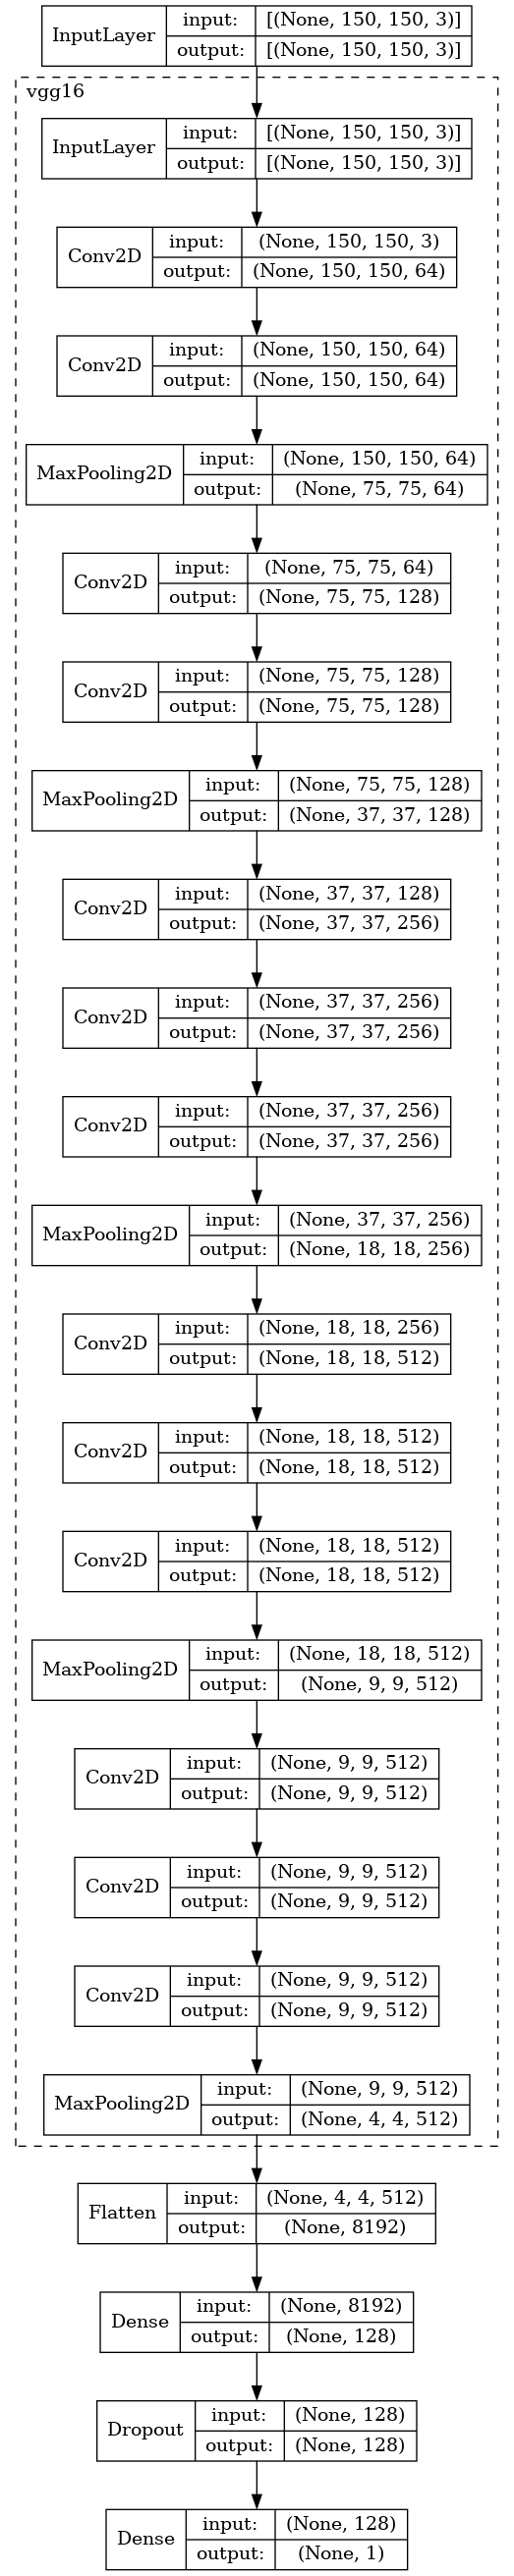

In [47]:
# Complete model
plot_model(vgg16_binary, to_file='vgg16_Binary.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

In [48]:
# set optmizer and learning rate
adam = Adam(0.001)

# Compile the model
vgg16_binary.compile(optimizer=adam,
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', patience=30, mode = 'min', verbose = 1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16(Binary).h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch')
# Train
history_binary = vgg16_binary.fit(
        train_gen,
#         steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=val_gen,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)


Epoch 1/200
17/17 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.7543
Epoch 1: val_loss improved from inf to 0.53285, saving model to vgg16(Binary).h5
17/17 [==============================] - 17s 962ms/step - loss: 0.6737 - accuracy: 0.7543 - val_loss: 0.5328 - val_accuracy: 0.7944
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8150
Epoch 2: val_loss improved from 0.53285 to 0.40226, saving model to vgg16(Binary).h5
17/17 [==============================] - 15s 867ms/step - loss: 0.4609 - accuracy: 0.8150 - val_loss: 0.4023 - val_accuracy: 0.8299
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8389
Epoch 3: val_loss improved from 0.40226 to 0.39743, saving model to vgg16(Binary).h5
17/17 [==============================] - 15s 908ms/step - loss: 0.3924 - accuracy: 0.8389 - val_loss: 0.3974 - val_accuracy: 0.8224
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss:

In [49]:
models.save_model(vgg16_binary, 'vgg16(Binary).h5')

In [50]:
# History of accuracy and loss
tra_loss_b = history_binary.history['loss']
tra_acc_b = history_binary.history['accuracy']
val_loss_b = history_binary.history['val_loss']
val_acc_b = history_binary.history['val_accuracy']

# Total number of epochs training
epochs_b = range(1, len(tra_acc_b)+1)
end_epoch_b = len(tra_acc_b)

# Epoch when reached the validation loss minimum
opt_epoch_b = val_loss_b.index(min(val_loss_b)) + 1

# Loss and accuracy on the validation set
end_val_loss_b = val_loss_b[-1]
end_val_acc_b = val_acc_b[-1]
opt_val_loss_b = val_loss_b[opt_epoch_b-1]
opt_val_acc_b = val_acc_b[opt_epoch_b-1]

# Loss and accuracy on the test set
opt_vgg16_b = models.load_model('vgg16(Binary).h5')
test_loss_b, test_acc_b = vgg16_binary.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_b, opt_test_acc_b = opt_vgg16_b.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Result\n")

print("Model Result\n")
print("Epoch [end]: %d" % end_epoch_b)
print("Epoch [opt]: %d\n" % opt_epoch_b)
print("Valid accuracy [end]: %.4f" % end_val_acc_b)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_b)
print("Test accuracy [end]:  %.4f" % test_acc_b)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_b)
print("Valid loss [end]: %.4f" % end_val_loss_b)
print("Valid loss [opt]: %.4f" % opt_val_loss_b)
print("Test loss [end]:  %.4f" % test_loss_b)
print("Test loss [opt]:  %.4f" % opt_test_loss_b)

VGG16 Result

Model Result

Epoch [end]: 80
Epoch [opt]: 50

Valid accuracy [end]: 0.8748
Valid accuracy [opt]: 0.8935
Test accuracy [end]:  0.8839
Test accuracy [opt]:  0.8839

Valid loss [end]: 0.3260
Valid loss [opt]: 0.2446
Test loss [end]:  0.2968
Test loss [opt]:  0.2968


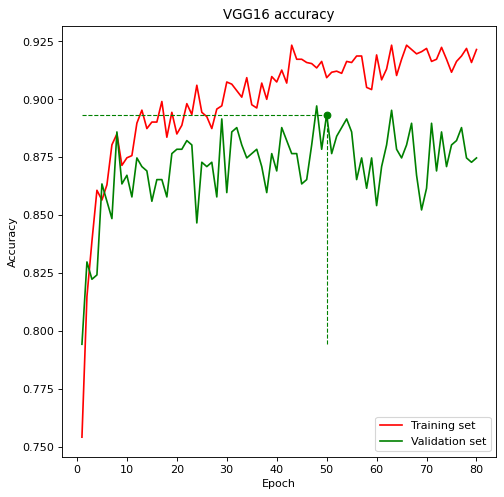

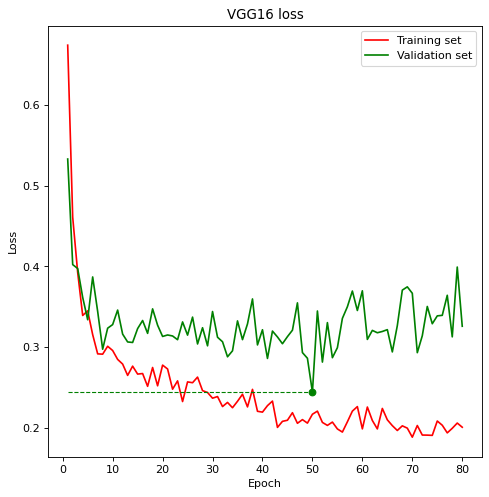

In [51]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_b, tra_acc_b, 'r', label='Training set')
plt.plot(epochs_b, val_acc_b, 'g', label='Validation set')
plt.plot(opt_epoch_b, val_acc_b[opt_epoch_b-1], 'go')
plt.vlines(opt_epoch_b, min(val_acc_b), opt_val_acc_b, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_b, 1, opt_epoch_b, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('Accuracy_figure_binary.png')
# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_b, tra_loss_b, 'r', label='Training set')
plt.plot(epochs_b, val_loss_b, 'g', label='Validation set')
plt.plot(opt_epoch_b, val_loss_b[opt_epoch_b-1], 'go')
plt.vlines(opt_epoch_b, min(val_loss_b), opt_val_loss_b, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_b, 1, opt_epoch_b, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('Loss_figure_binary.png')

In [54]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def get_errors(pred):
    errors = []
    mispred = []
    hard_mispred = []

    for l,p,img in zip(test_labels, pred, test_images):
        err = abs(l-p)
        errors.append(err)
        if err > 0.5:
            mispred.append((l,p,img))
        if err > 0.8:
            hard_mispred.append((l,p,img))

    return errors, mispred, hard_mispred


def show_error_stats(errors, mispred, hard_mispred):

    print("Number of test images: %d" % len(test_labels))
    print("Mispredictions: %d" % len(mispred))
    print("Hard mispred: %d" % len(hard_mispred))

    sns.distplot(errors, kde=False, rug=True, bins=10, vertical=False, label='samples', axlabel='error').set_title('Absolute error distribution');

    for l,p,img in hard_mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('mass' if l==0 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))
        plt.axis('off')

In [61]:
opt_model_vgg16_b = models.load_model('vgg16(Binary).h5')
pred = opt_model_vgg16_b.predict(test_images)

11/11 [==============================] - 0s 34ms/step


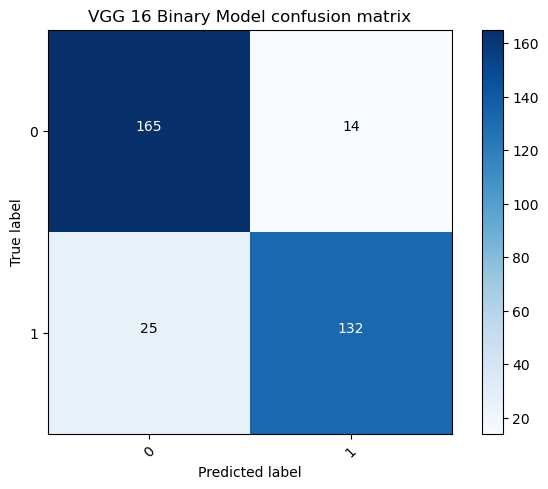

In [62]:
pred_vgg16_b = np.rint(pred)
confusion_mtx = confusion_matrix(test_labels, pred_vgg16_b) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='VGG 16 Binary Model confusion matrix')
plt.savefig('ConfusionMatrix.png')